In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install category_encoders

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

import plotly.express as px
import plotly.graph_objects as go
import category_encoders as ce

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# df = pd.read_csv("/content/drive/MyDrive/ML/BNP/train.csv.zip", compression="zip")
# train, test = train_test_split(df, train_size=0.7)

In [2]:
df = pd.read_csv("./dataset/Stockout/data.zip", compression="zip")
train, test = train_test_split(df, train_size=0.7, stratify=df['went_on_backorder'])
y_train = train.pop('went_on_backorder')
y_test = test.pop('went_on_backorder')

In [3]:
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
# categorical imputer
for cat_col in cat_cols:
    train[cat_col].fillna("__MISS__", inplace=True)
    test[cat_col].fillna("__MISS__", inplace=True)
# ordinal encoder
oe = OrdinalEncoder()
train[cat_cols] = oe.fit_transform(train[cat_cols])
test[cat_cols] = oe.transform(test[cat_cols])
# label encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
# numerical imputer
simple_imputer = SimpleImputer(strategy="median", copy=False)
train = simple_imputer.fit_transform(train)
test = simple_imputer.transform(test)

In [4]:
def plot_prob_dist(yhat_prob, y):
    plt.figure()
    preds = pd.DataFrame({"yhat_prob_test": yhat_prob[:,1], "y_test": y})
    sns.kdeplot(x=preds['yhat_prob_test'], hue=preds['y_test'])
    plt.title("Distibution of predicted probabilities")
    plt.xlabel("Predicted probabilities")
    plt.show()
    
def print_classification_report(clf, test, y_test):
    yhat_test = clf.predict(test)
    yhat_prob_test= clf.predict_proba(test)
    cm = confusion_matrix(y_test, yhat_test)
    print("********************************************************")
    print("Accuracy on Test data ", accuracy_score(y_test, yhat_test))
    print("********************************************************")
    print("Balanced Accuracy on Test data ", balanced_accuracy_score(y_test, yhat_test))
    print("********************************************************")
    print("AUC ROC on Test data ", roc_auc_score(y_test, yhat_test))
    print("********************************************************")
    print(classification_report(y_test, yhat_test))
    print("********************************************************")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    cm = confusion_matrix(y_test, yhat_test)
    ConfusionMatrixDisplay(cm).plot(ax=ax1)
    fpr, tpr, _ = roc_curve(y_test, yhat_test, pos_label=clf.classes_[1])
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax2)
    plot_prob_dist(yhat_prob_test, y_test)

### AdaBoost

## AdaBoost performance wrt no. of estimators

In [5]:
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score), 
           "F1 Score": make_scorer(f1_score), "BalancedAccuracy": make_scorer(balanced_accuracy_score)}

In [6]:
lr = [0.01, 0.1, 1]
params = {"learning_rate": lr}
base_clf = DecisionTreeClassifier(max_depth=1, random_state=1234)
clf = AdaBoostClassifier(base_estimator=base_clf, random_state=1234, n_estimators=100)
gs = GridSearchCV(clf, cv=5, n_jobs=-2, param_grid=params, scoring=scoring, return_train_score=True, refit="BalancedAccuracy")
gs.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                random_state=1234),
                                          n_estimators=100, random_state=1234),
             n_jobs=-2,
             param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 1]},
             refit='BalancedAccuracy', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'BalancedAccuracy': make_scorer(balanced_accuracy_score),
                      'F1 Score': make_scorer(f1_score)})

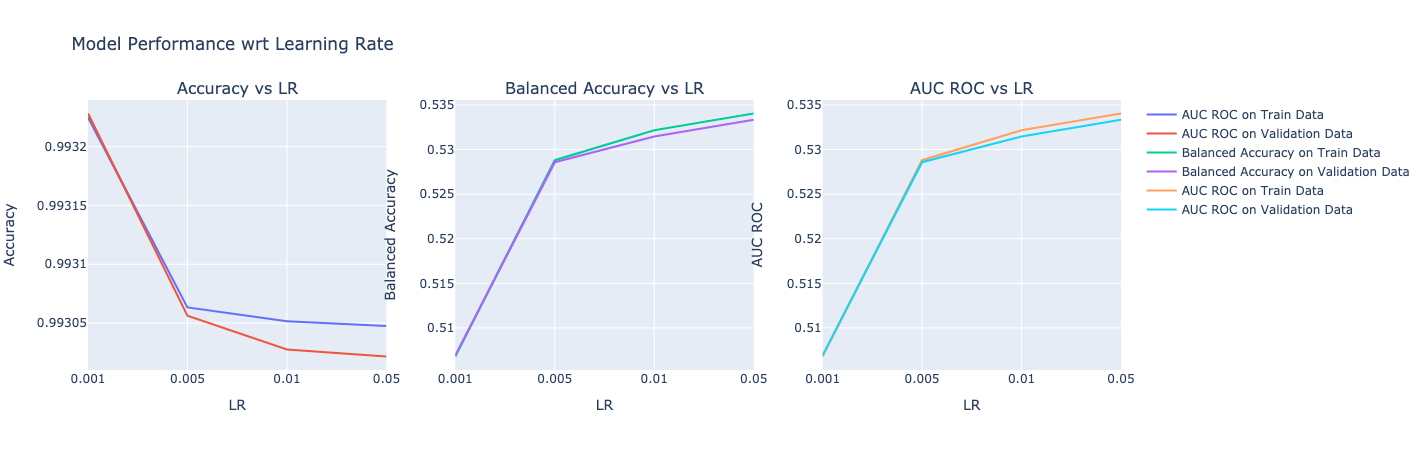

In [16]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Accuracy vs LR", "Balanced Accuracy vs LR", "AUC ROC vs LR"))
# accuracy
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'), row=1, col=1)
# f1 score
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_train_BalancedAccuracy'], mode='lines', name='Balanced Accuracy on Train Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_test_BalancedAccuracy'], mode='lines', name='Balanced Accuracy on Validation Data'),row=1, col=2)
# auc roc
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'), row=1, col=3)
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'),row=1, col=3)
# Update xaxis properties
fig.update_xaxes(title_text="LR", row=1, col=1, type='category')
fig.update_xaxes(title_text="LR", row=1, col=2, type='category')
fig.update_xaxes(title_text="LR", row=1, col=3, type='category')
# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Balanced Accuracy", row=1, col=2)
fig.update_yaxes(title_text="AUC ROC",  row=1, col=3)
# update layout
fig.update_layout(title='Model Performance wrt Learning Rate')
fig.show()

********************************************************
Accuracy on Test data  0.993002974180323
********************************************************
Balanced Accuracy on Test data  0.5291630348551328
********************************************************
AUC ROC on Test data  0.5291630348551328
********************************************************
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    502970
           1       0.36      0.06      0.10      3388

    accuracy                           0.99    506358
   macro avg       0.68      0.53      0.55    506358
weighted avg       0.99      0.99      0.99    506358

********************************************************


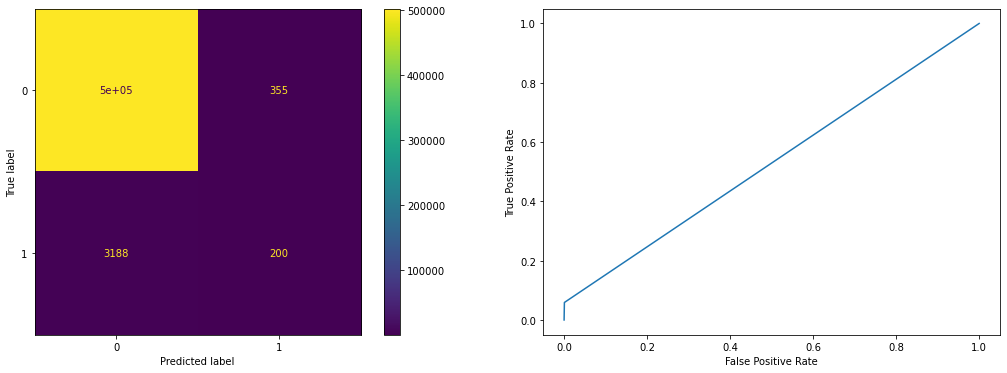

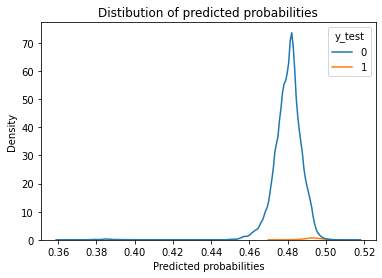

In [12]:
print_classification_report(gs.best_estimator_, test, y_test)

In [22]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

In [17]:
n_estimators = [100, 200, 300, 500]
params = {"n_estimators": n_estimators}
base_clf = DecisionTreeClassifier(max_depth=1, random_state=1234)
clf = AdaBoostClassifier(base_estimator=base_clf, random_state=1234, learning_rate=0.05)
gs = GridSearchCV(clf, cv=5, n_jobs=-2, param_grid=params, scoring=scoring, return_train_score=True, refit="BalancedAccuracy")
gs.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                random_state=1234),
                                          learning_rate=0.05,
                                          random_state=1234),
             n_jobs=-2, param_grid={'n_estimators': [100, 200, 300, 500]},
             refit='BalancedAccuracy', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'BalancedAccuracy': make_scorer(balanced_accuracy_score),
                      'F1 Score': make_scorer(f1_score)})

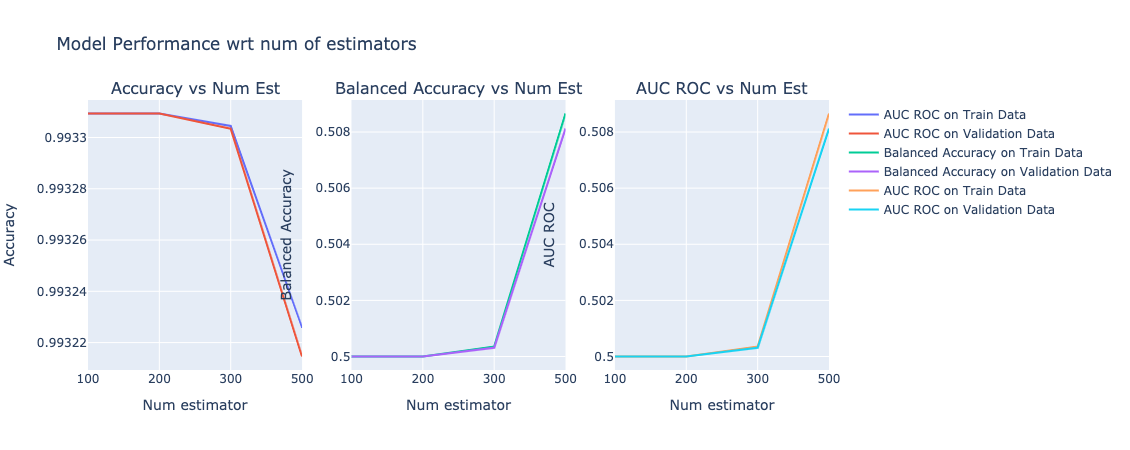

In [18]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Accuracy vs Num Est", "Balanced Accuracy vs Num Est", "AUC ROC vs Num Est"))
# accuracy
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'), row=1, col=1)
# f1 score
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_train_BalancedAccuracy'], mode='lines', name='Balanced Accuracy on Train Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_test_BalancedAccuracy'], mode='lines', name='Balanced Accuracy on Validation Data'), row=1, col=2)
# auc roc
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'), row=1, col=3)
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'), row=1, col=3)
# Update xaxis properties
fig.update_xaxes(title_text="Num estimator", row=1, col=1, type='category')
fig.update_xaxes(title_text="Num estimator", row=1, col=2, type='category')
fig.update_xaxes(title_text="Num estimator", row=1, col=3, type='category')
# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Balanced Accuracy", row=1, col=2)
fig.update_yaxes(title_text="AUC ROC",  row=1, col=3)
# update layout
fig.update_layout(title='Model Performance wrt num of estimators')
fig.show()

********************************************************
Accuracy on Test data  0.9932044126882561
********************************************************
Balanced Accuracy on Test data  0.5071300072610019
********************************************************
AUC ROC on Test data  0.5071300072610019
********************************************************
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    502970
           1       0.32      0.01      0.03      3388

    accuracy                           0.99    506358
   macro avg       0.66      0.51      0.51    506358
weighted avg       0.99      0.99      0.99    506358

********************************************************


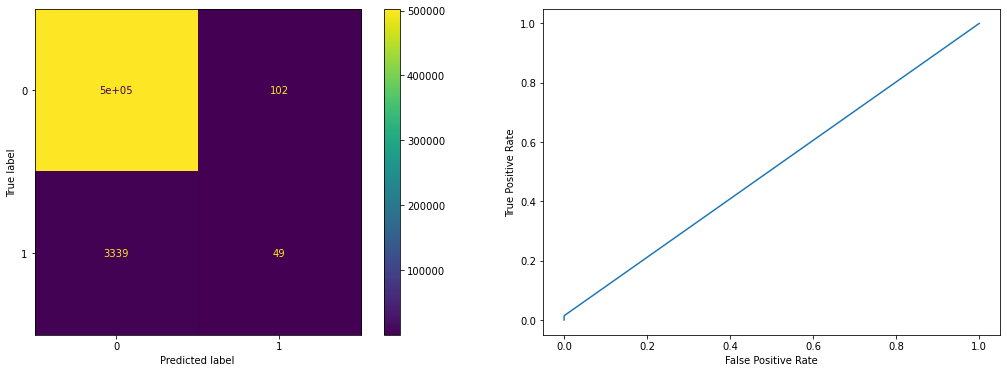

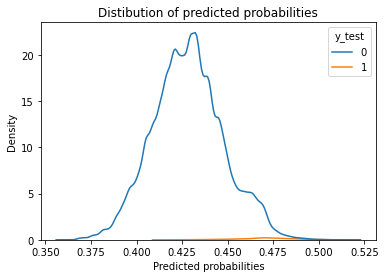

In [19]:
print_classification_report(gs.best_estimator_, test, y_test)

In [27]:
base_clf = DecisionTreeClassifier(max_depth=1, random_state=1234)
clf = AdaBoostClassifier(base_estimator=base_clf, random_state=1234, learning_rate=0.05, n_estimators=100)
clf.fit(train, y_train, sample_weight=sample_weights)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         random_state=1234),
                   learning_rate=0.05, n_estimators=100, random_state=1234)

********************************************************
Accuracy on Test data  0.8555508158259572
********************************************************
Balanced Accuracy on Test data  0.8504780505802616
********************************************************
AUC ROC on Test data  0.8504780505802616
********************************************************
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    502970
           1       0.04      0.85      0.07      3388

    accuracy                           0.86    506358
   macro avg       0.52      0.85      0.50    506358
weighted avg       0.99      0.86      0.92    506358

********************************************************


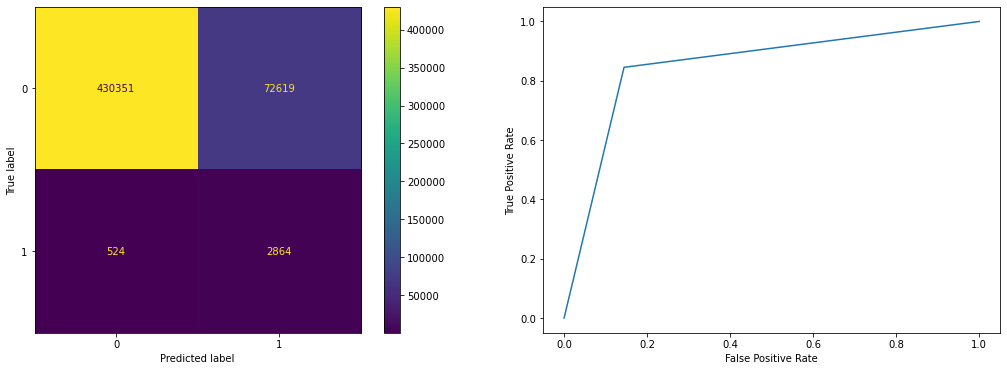

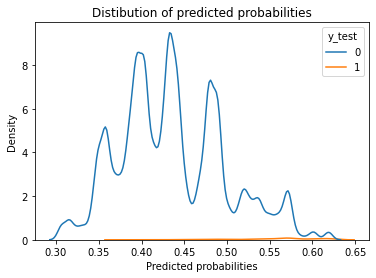

In [28]:
print_classification_report(clf, test, y_test)

In [32]:
clf.estimator_errors_

array([0.22444124, 0.23542147, 0.2511549 , 0.25551885, 0.27032343,
       0.27472864, 0.27548257, 0.28887824, 0.29907819, 0.29096298,
       0.30009863, 0.31395463, 0.31262826, 0.30660232, 0.31368609,
       0.31880632, 0.32180107, 0.32897171, 0.33990808, 0.33800733,
       0.34916606, 0.33631971, 0.35238624, 0.35444628, 0.35115685,
       0.36477928, 0.34963189, 0.37749586, 0.36745303, 0.38678215,
       0.36304878, 0.38452458, 0.39209546, 0.36125086, 0.36224399,
       0.3667499 , 0.39731277, 0.38999071, 0.36815066, 0.37913153,
       0.37440777, 0.37079921, 0.40207838, 0.39820761, 0.37379185,
       0.38618858, 0.38413762, 0.40631888, 0.38647709, 0.37949431,
       0.38507735, 0.38125994, 0.41112298, 0.40474456, 0.39081411,
       0.4035977 , 0.41494133, 0.38765642, 0.40629441, 0.38759304,
       0.39080213, 0.3896441 , 0.41250836, 0.41912367, 0.41050249,
       0.40411987, 0.39617735, 0.39322993, 0.42259353, 0.4172222 ,
       0.40342775, 0.41403596, 0.40031597, 0.40486794, 0.42642